In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
class_name = 'Occupancy'
df1 = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 =pd.read_csv('datatest.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df3=pd.read_csv('datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df4=pd.merge(df1, df2, how='outer')
df=pd.merge(df4, df3, how='outer')
df.shape


(20560, 7)

In [3]:
df['Day']=pd.to_datetime(df['date']).dt.day
df['Hour']=pd.to_datetime(df['date']).dt.hour
df['Month']=pd.to_datetime(df['date']).dt.month
df['Year']=pd.to_datetime(df['date']).dt.year
df['Data']=pd.to_datetime(df['date']).dt.normalize()
del df['date']

In [4]:
df['Day']=df['Data'].dt.dayofweek
df.drop(['Year','Month','Data'], axis='columns', inplace=True)
del df['HumidityRatio']

In [5]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

DATA PARTITIONING

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score ,cross_val_predict

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

RANDOM FOREST

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.992704280155642
F1-score [0.99525367 0.98423818]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.98      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



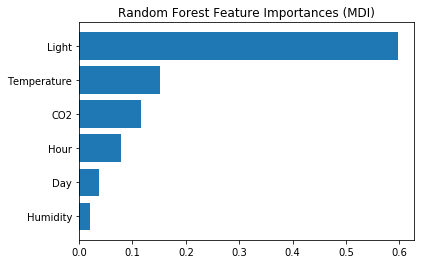

In [11]:
nbr_features = 6

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(feature_names)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [12]:
from sklearn.inspection import permutation_importance

In [13]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)

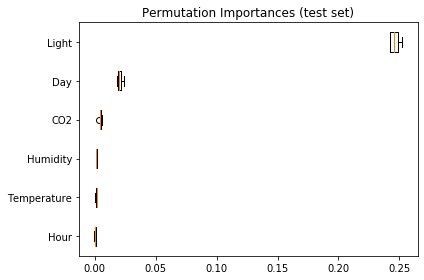

In [14]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [15]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Temperature 0.15161873611155866
Humidity 0.0196251295559592
Light 0.59727093521098
CO2 0.11660724531463507
Day 0.03670390420410387
Hour 0.07817404960276327


## Cross validation and hyperparameter tuning

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
randomfor=RandomForestClassifier()
scores = cross_val_score(randomfor, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(randomfor, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9730 (+/- 0.05)
F1-score: 0.9654 (+/- 0.06)


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [19]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

random_search = RandomizedSearchCV(randomfor, param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train, y_train)
randomfor = random_search.best_estimator_


y_pred_ranfor = randomfor.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_ranfor))
print('F1-score %s' % f1_score(y_test, y_pred_ranfor, average=None))
print(classification_report(y_test, y_pred_ranfor))

Accuracy 0.9920557717250325
F1-score [0.9948285  0.98287312]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.98      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [20]:
 random_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'min_samples_split': 30, 'min_samples_leaf': 1, 'max_depth': 11}

## Bagging

In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [28]:
clf = BaggingClassifier(base_estimator=None, n_estimators=10, random_state=0,bootstrap=True, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
clf.oob_score_

C:\Users\Gianmarco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Gianmarco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.9896470261256254

In [29]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9915693904020753
F1-score [0.99451824 0.98175439]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.98      0.98      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [30]:
clf = BaggingClassifier(base_estimator=SVC(C=1000), n_estimators=10, random_state=0,bootstrap=True, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
clf.oob_score_

C:\Users\Gianmarco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Gianmarco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.9869371873262924

In [25]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

0.9869371873262924

In [26]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=10, random_state=0,bootstrap=True, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

C:\Users\Gianmarco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Gianmarco\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


Accuracy 0.9930285343709468
F1-score [0.99546366 0.98494925]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.98      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [27]:
clf.oob_score_

0.9906197887715398

### Boosting

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [35]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.99189364461738
F1-score [0.99471235 0.98263889]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [35]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9925421530479897
F1-score [0.99514973 0.98387097]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.98      0.98      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

